In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import cohen_kappa_score,confusion_matrix,classification_report,plot_roc_curve
from sklearn.naive_bayes import BernoulliNB,GaussianNB,MultinomialNB,ComplementNB
import warnings
warnings.filterwarnings("ignore")

# 一、数据分析

In [2]:
data=pd.read_csv('/Users/singal/Desktop/MLPython_Data/spam.csv')
data.shape

(4601, 58)

In [3]:
data.info

<bound method DataFrame.info of        A.1   A.2   A.3  A.4   A.5   A.6   A.7   A.8   A.9  A.10  ...   A.49  \
0     0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.000   
1     0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.000   
2     0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.010   
3     0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.000   
4     0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.000   
...    ...   ...   ...  ...   ...   ...   ...   ...   ...   ...  ...    ...   
4596  0.31  0.00  0.62  0.0  0.00  0.31  0.00  0.00  0.00  0.00  ...  0.000   
4597  0.00  0.00  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.000   
4598  0.30  0.00  0.30  0.0  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.102   
4599  0.96  0.00  0.00  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.000   
4600  0.00  0.00  0.65  0.0  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.000   

       A.50  A.51  

In [4]:
data.spam.value_counts()

email    2788
spam     1813
Name: spam, dtype: int64

In [5]:
data.spam.value_counts(normalize=True)

email    0.605955
spam     0.394045
Name: spam, dtype: float64

考察特征向量的分布特征。

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

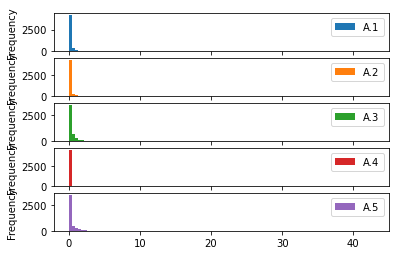

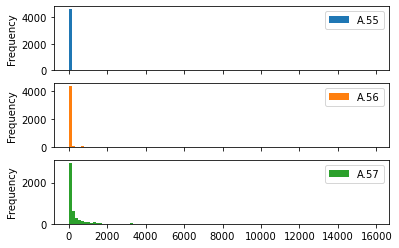

In [6]:
data.iloc[:,:5].plot.hist(subplots=True,bins=100)
data.iloc[:,-4:].plot.hist(subplots=True,bins=100)

特征向量各分量均为非负的连续型变量。

In [7]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)

# 二、朴素贝叶斯 Naive Bayes
## 1、高斯朴素贝叶斯
$$ p(x_{ij}|y_i=k)\sim N(\mu,\sigma)$$
特征变量$x_{ij}$的条件概率$ p(x_{ij}|y_i=k)$服从正态分布。

In [8]:
model=GaussianNB()
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.8447339847991314

## 2、多项朴素贝叶斯
特征变量$x_{ij}$的条件概率$ p(x_{ij}|y_i=k)$服从多项分布。

In [9]:
model=MultinomialNB()#alpha默认为1
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.7915309446254072

## 3、互补朴素贝叶斯
互补朴素贝叶斯是多项朴素贝叶斯的改进版本。

In [10]:
model=MultinomialNB(alpha=0)#设置拉普拉斯修正为0,会导致“数值错误”。
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.7926167209554832

In [11]:
model=ComplementNB()
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.7893593919652552

## 4、伯努利朴素贝叶斯
1. 特征变量$x_{ij}$的条件概率$ p(x_{ij}|y_i=k)$服从两点分布。
2. 伯努利朴素贝叶斯，默认以0作为门槛值，大于0的特征变量取值变为1，反之为0。

In [12]:
model=BernoulliNB(binarize=0,alpha=1)
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.8925081433224755

## 5、上述结果显示，伯努利朴素贝叶斯的预测准确率最高。
原因如下：
1. 特征变量取值大多集中在0附近。
2. 条件概率不服从严格的正态分布。

# 三、考察超参数 hyperparameter
1. binarize表示定义两点分布的门槛。
2. alpha表示拉普拉斯修正。

## 1、双重for循环
通过选择这两个参数，最大化测试集的预测概率score。

In [13]:
best_score=0
for binarize in np.arange(0,1.1,0.1):
    for alpha in np.arange(0,1.1,0.1):
        model=BernoulliNB(binarize=binarize,alpha=alpha)
        model.fit(xtrain,ytrain)
        score=model.score(xtest,ytest)
        if score>best_score:
            best_score = score
            best_params={'binarize':binarize,'alpha':alpha}

In [14]:
best_score,best_params

(0.9218241042345277, {'binarize': 0.30000000000000004, 'alpha': 1.0})

## 2、解决过拟合
1. 根据测试集的预测效果来选择超参数，严格来说等于提前泄露测试集的信息，不仅拟合了数据中的信号，而且拟合了噪音。
2. 最能预测测试集的超参数，对于未预见的数据未必也是最佳超参数。

解决方法：
1. 将全样本一分为三，即训练集、验证集和测试集，以此用于估计模型、选择超参数、评估测试误差。
2. 交叉验证法CV。

### （1）方法一

In [15]:
xtrainval,xtest,ytrainval,ytest=train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)
xtrain,xval,ytrain,yval=train_test_split(xtrainval,ytrainval,stratify=ytrainval,random_state=123,test_size=0.25)

In [16]:
best_val_score=0
for binarize in np.arange(0,1.1,0.1):
    for alpha in np.arange(0,1.1,0.1):
        model=BernoulliNB(binarize=binarize,alpha=alpha)
        model.fit(xtrain,ytrain)
        score=model.score(xval,yval)
        if score>best_val_score:
            best_val_score=score
            best_val_params={'binarize':binarize,'alpha':alpha}

In [17]:
best_val_score,best_val_params

(0.9065217391304348, {'binarize': 0.30000000000000004, 'alpha': 0.1})

使用训练集和验证集的合集，进行二项朴素贝叶斯估计。

In [18]:
model=BernoulliNB(**best_val_params)#未匹配的关键字参数
model.fit(xtrainval,ytrainval)
model.score(xtest,ytest)

0.9207383279044516

### （2）方法二

In [19]:
best_score=0
kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
for binarize in np.arange(0,1.1,0.1):
    for alpha in np.arange(0,1.1,0.1):
        model=BernoulliNB(binarize=binarize,alpha=alpha)
        scores=cross_val_score(model,xtrainval,ytrainval,cv=kfold)
        score=np.mean(scores)
        if best_score<score:
            best_score=score
            best_params={'binarize':binarize,'alpha':alpha}

In [20]:
best_score,best_params

(0.8994565217391305, {'binarize': 0.1, 'alpha': 0.0})

In [21]:
model=BernoulliNB(**best_params)
model.fit(xtrainval,ytrainval)
model.score(xtest,ytest)

0.9153094462540716

## 3、GridSearchCV
网格搜寻超参数，并交叉验证。

In [22]:
param_grid={'binarize':np.arange(0,1.1,0.1),'alpha':np.arange(0,1.1,0.1)}
model=GridSearchCV(BernoulliNB(),param_grid,cv=kfold)#cv默认为10
model.fit(xtrainval,ytrainval)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=BernoulliNB(),
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'binarize': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [23]:
model.score(xtest,ytest),model.best_params_,model.best_score_#返回交叉验证的最佳预测准确率

(0.9153094462540716, {'alpha': 0.0, 'binarize': 0.1}, 0.8994565217391305)

In [24]:
results=pd.DataFrame(model.cv_results_)#每个超参数组合的详细交叉验证信息
results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_binarize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007783,0.001289,0.001161,0.000119,0.0,0.0,"{'alpha': 0.0, 'binarize': 0.0}",0.885870,0.907609,0.858696,0.894022,0.888587,0.883152,0.877717,0.855978,0.899457,0.891304,0.884239,0.015620,67
1,0.007383,0.001672,0.001153,0.000233,0.0,0.1,"{'alpha': 0.0, 'binarize': 0.1}",0.910326,0.926630,0.877717,0.904891,0.902174,0.904891,0.885870,0.875000,0.910326,0.896739,0.899457,0.015179,1


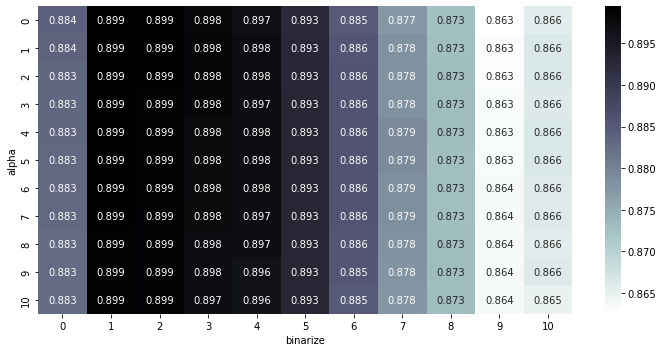

In [25]:
plt.figure(figsize=(10,5))
scores=np.array(results.mean_test_score).reshape(11,11)
sns.heatmap(scores,annot=True,cmap='bone_r',fmt='.3f')
plt.xlabel('binarize')
plt.ylabel('alpha')
plt.tight_layout()

# 四、多分类模型评估
多分类模型评估的四板斧：
1. confusion_matrix
2. classification_report
3. cohen_kappa_score
4. ROC curve

In [26]:
prob=model.predict_proba(xtest)
pred=model.predict(xtest)
print(prob[:3],pred[:3],sep='\n-----------\n')

[[4.74516086e-05 9.99952548e-01]
 [9.99997682e-01 2.31825593e-06]
 [9.98936191e-01 1.06380916e-03]]
-----------
['spam' 'email' 'email']


In [27]:
table=pd.crosstab(ytest,pred,colnames=['Predicted'],rownames=['Actual'])
table

Predicted,email,spam
Actual,,
email,525,33
spam,45,318


In [28]:
table=np.array(table)
accuracy=(table[0,0]+table[1,1])/table.sum()
error_rate=1-accuracy
sensitivity=(table[1,1])/table[1,:].sum()
specificity=table[0,0]/table[0,:].sum()
recall=table[1,1]/table[:,1].sum()
accuracy,error_rate,sensitivity,specificity,recall

(0.9153094462540716,
 0.08469055374592838,
 0.8760330578512396,
 0.9408602150537635,
 0.905982905982906)

In [29]:
print('混淆矩阵：\n',confusion_matrix(ytest,pred))
print('科恩的kappa指标：\n',cohen_kappa_score(ytest,pred))
print('报告：\n',classification_report(ytest,pred))

混淆矩阵：
 [[525  33]
 [ 45 318]]
科恩的kappa指标：
 0.821639256346085
报告：
               precision    recall  f1-score   support

       email       0.92      0.94      0.93       558
        spam       0.91      0.88      0.89       363

    accuracy                           0.92       921
   macro avg       0.91      0.91      0.91       921
weighted avg       0.92      0.92      0.92       921



Text(0.5, 1.0, 'ROC Curve for Bounoulli Naive Bayes')

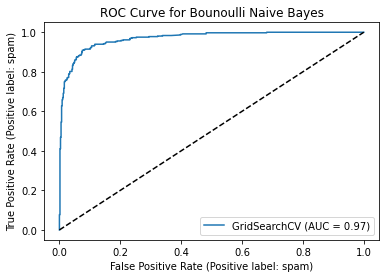

In [30]:
plot_roc_curve(model,xtest,ytest)
x=np.linspace(0,1,100)
plt.plot(x,x,'k--')
plt.title('ROC Curve for Bounoulli Naive Bayes')

# 五、绘制决策边界（示例）

In [31]:
from sklearn.datasets import load_iris
from mlxtend.plotting import plot_decision_regions
X,y=load_iris(return_X_y=True)
X2=X[:,-2:]
model=GaussianNB()
model.fit(X2,y)
model.score(X2,y)

0.96

Text(0.5, 1.0, 'Decision Boundary for Gaussian Navie Bayes')

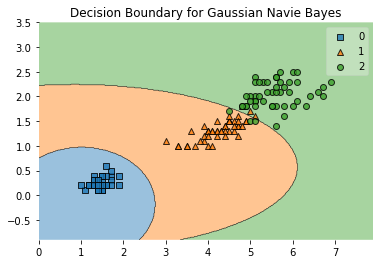

In [32]:
plot_decision_regions(X2,y,model)
plt.title('Decision Boundary for Gaussian Navie Bayes')